# 数据增强
前面我们已经讲了几个非常著名的卷积网络的结构，但是单单只靠这些网络并不能取得 state-of-the-art 的结果，现实问题往往更加复杂，非常容易出现过拟合的问题，而数据增强的方法是对抗过拟合问题的一个重要方法。

2012 年 AlexNet 在 ImageNet 上大获全胜，图片增强方法功不可没，因为有了图片增强，使得训练的数据集比实际数据集多了很多'新'样本，减少了过拟合的问题，下面我们来具体解释一下。

## 一.常用的数据增强方法
常用的数据增强方法如下：
1. 对图片进行一定比例缩放
2. 对图片进行随机位置的截取
3. 对图片进行随机的水平和竖直翻转
4. 对图片进行随机角度的旋转
5. 对图片进行亮度、对比度和颜色的随机变化

这些方法 pytorch 都已经为我们内置在了 torchvision 里面，我们在安装 pytorch 的时候也安装了 torchvision，下面我们来依次展示一下这些数据增强方法

In [1]:
import sys
sys.path.append('..')
from PIL import Image
from torchvision import transforms as tfs#数据增强的模块

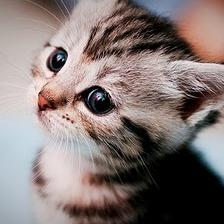

In [3]:
im=Image.open('./cat.png') #打开一幅图
im

### 1.随机比例缩放

<class 'PIL.PngImagePlugin.PngImageFile'>
before scale shape:(224, 224)
<class 'PIL.Image.Image'>
after scale shape:(200, 100)


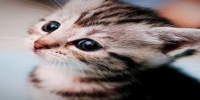

In [9]:
print(type(im))
print('before scale shape:{}'.format(im.size))
new_im=tfs.Resize((100,200))(im)
print(type(new_im))
print('after scale shape:{}'.format(new_im.size))
new_im

### 2.随机位置截取

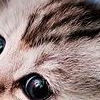

In [6]:
random_im1=tfs.RandomCrop(100)(im)
random_im1

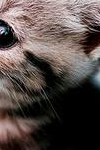

In [7]:
random_im2=tfs.RandomCrop((150,100))(im)
random_im2

<class 'PIL.Image.Image'>


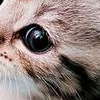

In [8]:
center_im=tfs.CenterCrop(100)(im)
print(type(center_im))
center_im

### 3.随机的水平和竖直方向翻转

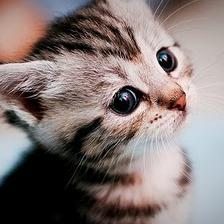

In [12]:
h_flip=tfs.RandomHorizontalFlip()(im)#也可能随机转两次,转回来了. flip denotes "翻转",horizontal denotes '水平的'
h_flip

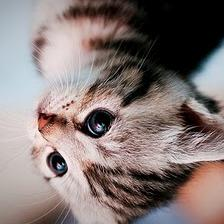

In [14]:
v_flip=tfs.RandomVerticalFlip()(im) #vertical denotes "竖直的"
v_flip

### 4.随机角度旋转
一些角度的旋转仍然是非常有用的数据增强方式，在 torchvision 中，使用 torchvision.transforms.RandomRotation() 来实现，其中第一个参数就是随机旋转的角度，比如填入 10，那么每次图片就会在 -10 ~ 10 度之间随机旋转

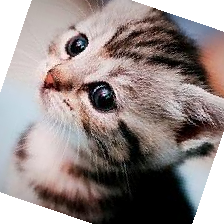

In [15]:
rot_im=tfs.RandomRotation(45)(im)
rot_im

### 5.亮度、对比度和颜色的变化
除了形状变化外，颜色变化又是另外一种增强方式，其中可以设置亮度变化，对比度变化和颜色变化等，在 torchvision 中主要使用 torchvision.transforms.ColorJitter() 来实现的，第一个参数就是亮度的比例，第二个是对比度，第三个是饱和度，第四个是颜色

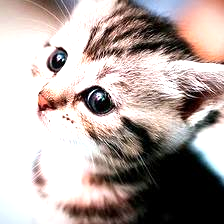

In [16]:
#亮度
bright_im=tfs.ColorJitter(brightness=1)(im)
bright_im

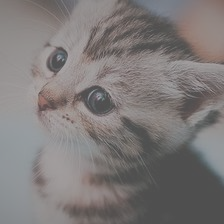

In [24]:
#对比度
contrast_im=tfs.ColorJitter(contrast=1)(im)
contrast_im

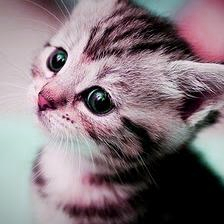

In [25]:
# 颜色
color_im=tfs.ColorJitter(hue=0.5)(im)# 随机从 -0.5 ~ 0.5 之间对颜色变化
color_im

上面我们讲了这么图片增强的方法，其实这些方法都不是孤立起来用的，可以联合起来用，比如先做随机翻转，然后随机截取，再做对比度增强等等，torchvision 里面有个非常方便的函数能够将这些变化合起来，就是 torchvision.transforms.Compose()，下面我们举个例子

In [26]:
im_aug=tfs.Compose([tfs.Resize(120),
                    tfs.RandomHorizontalFlip(),
                   tfs.RandomCrop(96),
                   tfs.ColorJitter(brightness=0.5,contrast=0.5,hue=0.5)])

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

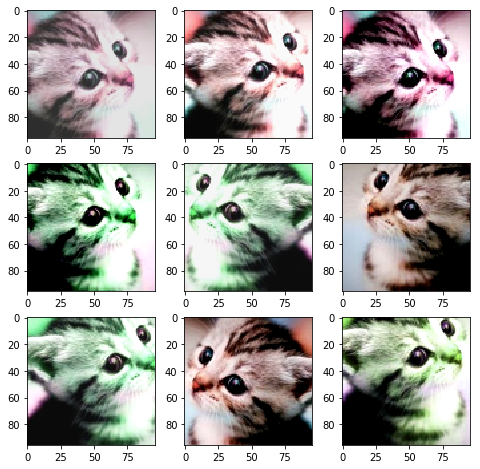

In [28]:
nrows=3#3行
ncols=3#3列
figsize=(8,8)#每个图片的大小
_,figs=plt.subplots(nrows,ncols,figsize=figsize)
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(im_aug(im))
plt.show()

## 二.DataAugumentaion在Resnet上的实验

In [30]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from utils import train,resnet
from torchvision import transforms as tfs

In [ ]:
#使用数据增强
def train_tf(x):
    im_aug=tfs.Compose([tfs.Resize(120),
                       tfs.RandomHorizontalFlip(),
                       tfs.RandomCrop(96),
                       tfs.ColorJitter(brightness=0.5,contrast=0.5,hue=0.5),
                       tfs.ToTensor(),
                       tfs.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    x=im_aug(x)
    return x
def test_tf(x):
    im_aug=tfs.Compose([tfs.Resize(96),
                       tfs.ToTensor(),
                       tfs.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
    x=im_aug(x)
    return x
train_set=CIFAR10('./data',train=True,transform=train_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10('./data', train=False, transform=test_tf)
test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train(net, train_data, test_data, 10, optimizer, criterion)

In [ ]:
# 不使用数据增强
def data_tf(x):
    im_aug = tfs.Compose([
        tfs.Resize(96),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x

train_set = CIFAR10('./data', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10('./data', train=False, transform=data_tf)
test_data = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

net = resnet(3, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

从上面可以看出，对于训练集，不做数据增强跑 10 次，准确率已经到了 95%，而使用了数据增强，跑 10 次准确率只有 75%，说明数据增强之后变得更难了。

而对于测试集，使用数据增强进行训练的时候，准确率会比不使用更高，因为数据增强提高了模型应对于更多的不同数据集的泛化能力，所以有更好的效果。